# Image Classification with PyTorch
***
Nov 20

Credits:
Adapted from Tim Wheler's notebook. Thanks Tim.
Animations adapted from: Aleksandr Antonov

## Verify Pytorch Installation and Prerequisite Packages

- `torch` - Tensors, Autograd, NNs
- `torchvision` - Vision (image/video) datasets, models and utilities
- `torcheval` - Metrics for evaluation
- `tqdm` - Progress bars

If you don't have `matplotlib` and `seaborn` already, install those as well.

In [ ]:
!pip show torch torchvision torcheval tqdm

# Uncomment the line below to install
# !pip install torch torchvision torcheval tqdm

In [2]:
from pathlib import Path

import numpy as np
import seaborn as sns
import torch
from IPython.display import HTML
from matplotlib import pyplot as plt, rc
from matplotlib.animation import ArtistAnimation
from matplotlib.legend_handler import HandlerTuple
from torch.nn import (
    CrossEntropyLoss,
    Linear,
    Module,
    Parameter,
    Sequential,
    Sigmoid,
)
from torch.optim import Adam
from torch.utils.data import DataLoader, SubsetRandomSampler
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
)
from torchvision import transforms as T
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm


rc("animation", html="html5")
rc("mathtext", fontset="dejavuserif")

LINESEP = "-" * 80
torch.manual_seed(43)

###  Hardware Acceleration = Speed!

If you're using Google Collab, the runtime can be changed to use a GPU. Under Runtime> Change Runtime Type> Hardware Accelerator > GPU.

Scorpio/TuxWorld not have GPUs.

In [3]:
if torch.cuda.is_available():
    dev = torch.cuda.current_device()
    print(torch.cuda.get_device_name(dev))
    print(torch.cuda.device_count())
else:
    print("Using CPU")

Using CPU


## Finding the Minima/Maxima of a Curve

In [4]:
def convex_func(x):
    return torch.sum(torch.pow(x, 2.0))


def nonconvex_func(x):
    """
    $sin(x) + sin(\frac{10}{3}x)$
    """
    return torch.sin(x) + torch.sin((10.0 / 3.0) * x)

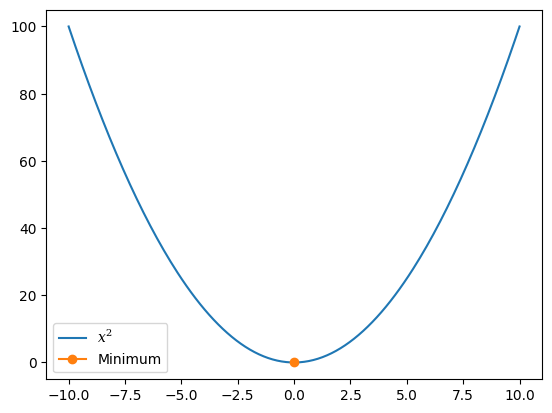

In [5]:
x_init = torch.linspace(-10, 10, 200)
y_init = [convex_func(e) for e in x_init]
plt.plot(x_init, y_init, label="$x^2$")
plt.plot(0, 0, marker="o", label="Minimum")
plt.legend(loc="lower left")
plt.show()

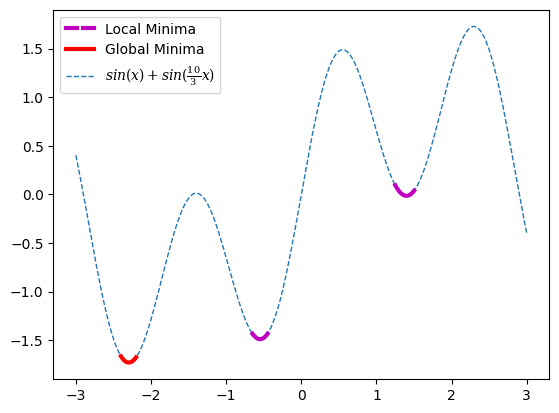

In [6]:
x_init = torch.linspace(-3, 3, 200)
y_init = [nonconvex_func(e) for e in x_init]
(plt_h,) = plt.plot(x_init, y_init, linestyle="dashed", linewidth=1)

local_minima = [(-0.65, -0.45), (1.25, 1.5)]

minima_handles = []
for start, end in local_minima:
    x_minima = torch.linspace(start, end, 40)
    y_minima = [nonconvex_func(e) for e in x_minima]
    (h,) = plt.plot(x_minima, y_minima, "m", linewidth=3)
    minima_handles.append(h)

x_minima = torch.linspace(-2.4, -2.2, 40)
y_minima = [nonconvex_func(e) for e in x_minima]
(max_h,) = plt.plot(x_minima, y_minima, "r", linewidth=3)

plt.legend(
    [tuple(minima_handles), max_h, plt_h],
    ["Local Minima", "Global Minima", "$sin(x) + sin(\\frac{10}{3}x)$"],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc="upper left",
)
plt.show()

In [7]:
def plot_gradient_descent(
    function, start_x, iterations=100, lr=float("1e-2"), precision=float("1e-4")
):
    # Adapted from Aleksandr Antonov

    images = []
    fig, ax = plt.subplots(figsize=(10, 10))
    px = float(start_x)  # Starting x coordinate

    # Plot the base function
    x_init = torch.linspace(-10, 10, 200)
    y_init = [function(e) for e in x_init]
    f = plt.plot(x_init, y_init, color="k")

    for frame in range(iterations):
        old_px = px  # Saving old px value to calculate step

        # torch requires tensors, so convert to tensors
        # Calculate y, and gradient.
        px = torch.tensor([px], requires_grad=True)
        py = function(px)
        py.backward()
        gradient = px.grad.data

        # Convert px and py to floats for matplotlib
        px = px.item()
        py = py.item()

        # Everything is back to floats and arrays, so normal matplotlib now.
        # Plot the point
        point = plt.scatter(px, py, color="r", zorder=2.5)

        # Plot tangent line to the graph at (px, py) point
        # slope = derivative(px)
        slope = gradient.item()
        y_intercept = py - slope * px
        tx = np.arange(px - 1, px + 2, 2)  # X coordinates of tangent line
        ty = slope * tx + y_intercept  # Y coordinates of tangent line
        tangent = plt.plot(tx, ty, "r--")

        # Calculate new value of px
        px = px - lr * slope
        step = old_px - px

        # Plot text info
        bbox_args = dict(boxstyle="round", fc="0.8")
        arrow_args = dict(arrowstyle="->", color="b", linewidth=1)
        text = (
            f"Iteration: {frame}\n"
            f"Point: ({px:.2f}, {py:.2f})\n"
            f"Slope: {slope:.2f}\n"
            f"Step: {step:.4f}"
        )
        text = ax.annotate(
            text,
            xy=(px, py),
            xytext=(0.7, 0.9),
            textcoords="axes fraction",
            bbox=bbox_args,
            arrowprops=arrow_args,
            fontsize=12,
        )

        plt.title(f"{function.__name__} - Grad Desc starting at $x={start_x}$")
        images.append([f[0], tangent[0], point, text])

    anim = ArtistAnimation(fig, images)
    anim.save(
        f"{function.__name__}-gradient-descent-start{start_x}.gif",
        writer="pillow",
        fps=2,
    )
    HTML(anim.to_html5_video())

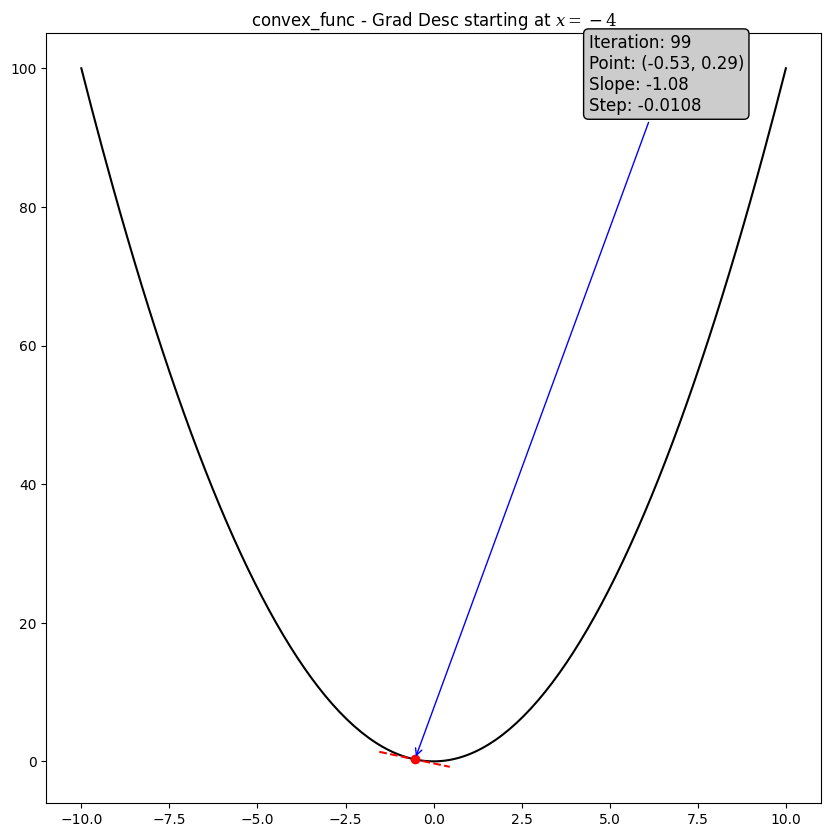

In [8]:
plot_gradient_descent(convex_func, start_x=-4)

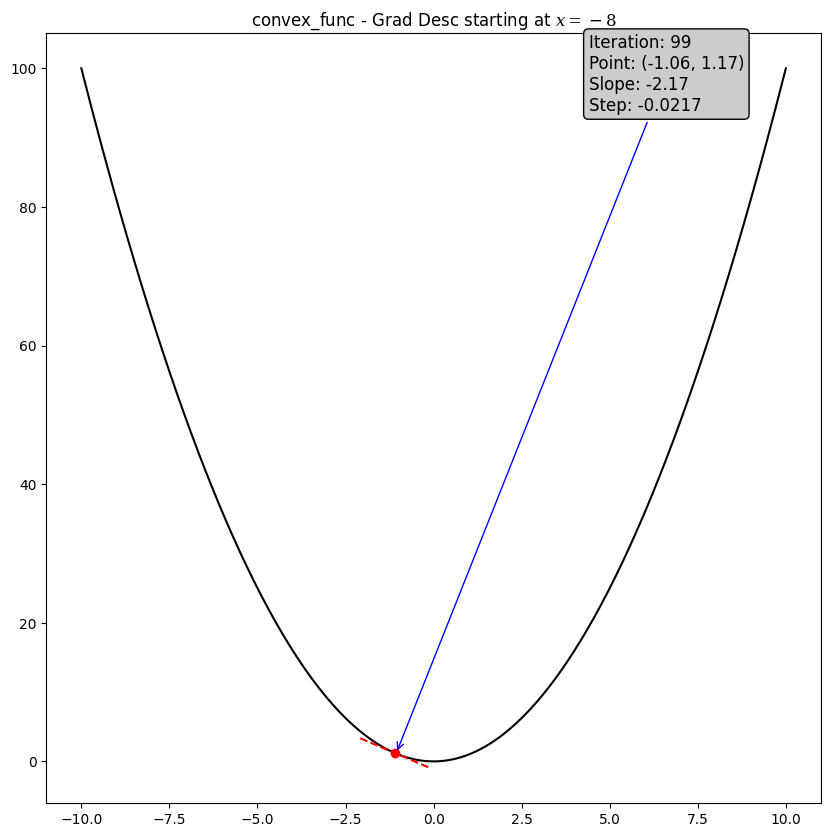

In [9]:
plot_gradient_descent(convex_func, start_x=-8)

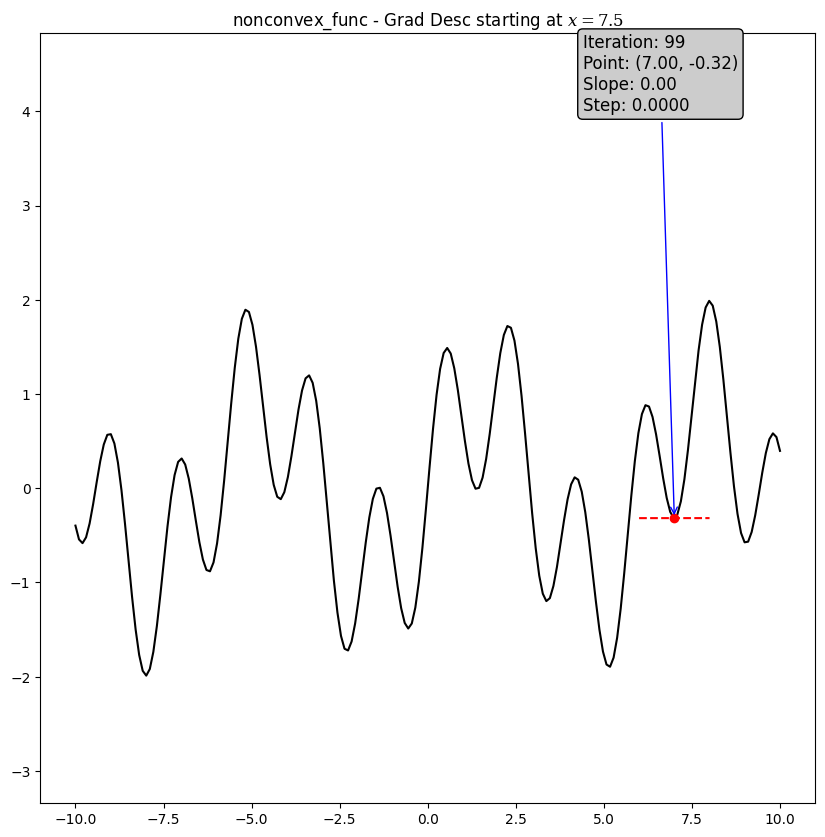

In [10]:
plot_gradient_descent(nonconvex_func, start_x=7.5)

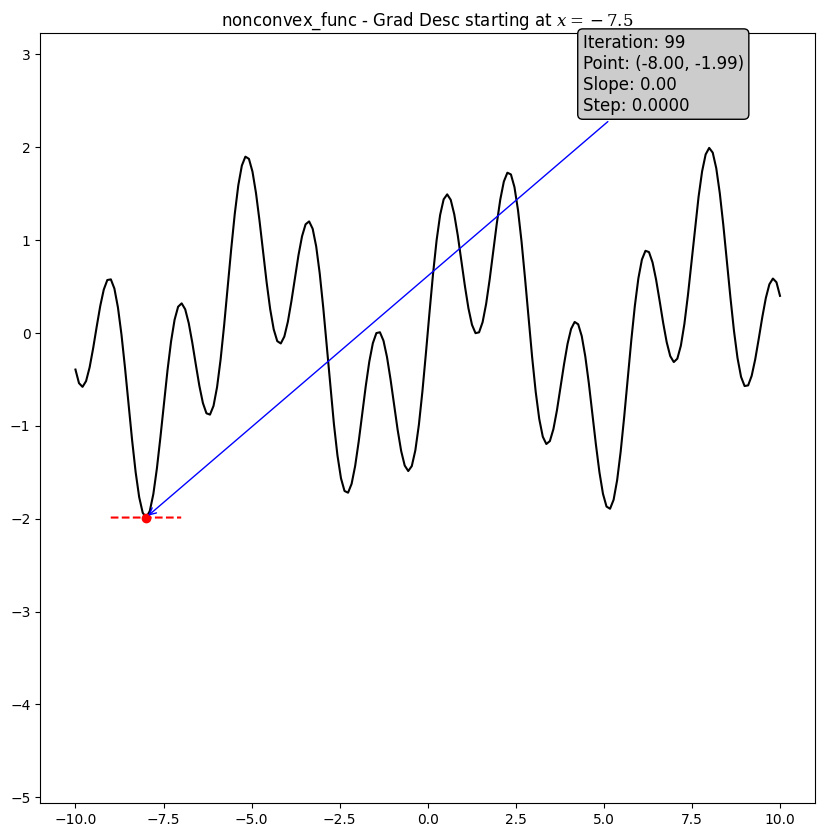

In [11]:
plot_gradient_descent(nonconvex_func, start_x=-7.5)

## Towards Neural Networks

In [12]:
def dense(x, W, b):
    return torch.sigmoid(torch.matmul(x, W) + b)


def multilayer_perceptron(x, w0, b0, w1, b1):
    x = dense(x, w0, b0)
    x = dense(x, w1, b1)
    return x


w0 = Parameter(torch.randn(2, 3, dtype=torch.float32, requires_grad=True))

b0 = Parameter(torch.randn(1, 3, dtype=torch.float32, requires_grad=True))

w1 = Parameter(torch.randn(3, 2, dtype=torch.float32, requires_grad=True))

b1 = Parameter(torch.randn(1, 2, dtype=torch.float32, requires_grad=True))

x = torch.randn(1, 2, dtype=torch.float32)

print(multilayer_perceptron(x, w0, b0, w1, b1))

tensor([[0.2536, 0.7814]], grad_fn=<SigmoidBackward0>)


In [13]:
layers = [Linear(2, 3), Sigmoid(), Linear(3, 2), Sigmoid()]
perceptron = Sequential(*layers)
perceptron[0].parameters

<bound method Module.parameters of Linear(in_features=2, out_features=3, bias=True)>

## FashionMNIST Image Classification

`FashionMNIST` is a dataset of fashion images from Zalando's articles. It has $60,000$ training images and $10,000$ test images. Each image is a  $28\times28$ grayscale image, and there are $10$ labeled classes.

This dataset is available through PyTorch, through the `torchvision.datasets` module. It's only $~84$MB, so it shouldn't take long to download, and you only need to download it once.





In [ ]:

# TODO: Change dataset path.
dataset_folder = None

dataset_folder = Path().resolve() / ".data" / "fashion-mnist"
print(f"Dataset Folder: {dataset_folder}")

assert dataset_folder, "Please define your FashionMNIST Download Directory!"

Let's begin by downloading the dataset to the aforementioned directory. 

You'll note that the constructor has a `transform` argument. The dataset is downloaded as a collection of human-readable images. These need to end up as `torch.Tensor` before being used in the model.

We use transforms to manipulate the data and make it suitable for training. For this example, we'll just use one transform, `ToTensor()`, to turn the Image into a `torch.Tensor()` object.

[You can see a list of transforms here.](https://pytorch.org/vision/0.15/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)


In [ ]:
transform = T.Compose([T.ToTensor()])

train_set = FashionMNIST(
    root=dataset_folder, download=True, train=True, transform=transform
)
print(f"Train Set Info:\n{LINESEP}\n{train_set}")
test_set = FashionMNIST(
    root=dataset_folder, download=True, train=False, transform=transform
)
print(f"Test Set Info:\n{LINESEP}\n{test_set}")

In [16]:
print(f"FashionMNIST Dataset Files:\n{LINESEP}")
print(
    "\n".join(
        sorted(
            [
                f"\t- {f.name} - {f.stat().st_size/(1<<20):,.02f}MB"
                for f in dataset_folder.rglob("*")
                if f.is_file()
            ]
        )
    )
)

FashionMNIST Dataset Files:
--------------------------------------------------------------------------------
	- t10k-images-idx3-ubyte - 7.48MB
	- t10k-images-idx3-ubyte.gz - 4.22MB
	- t10k-labels-idx1-ubyte - 0.01MB
	- t10k-labels-idx1-ubyte.gz - 0.00MB
	- train-images-idx3-ubyte - 44.86MB
	- train-images-idx3-ubyte.gz - 25.20MB
	- train-labels-idx1-ubyte - 0.06MB
	- train-labels-idx1-ubyte.gz - 0.03MB


This dataset is downloaded as a set of `.gz` (**G**NU **Z**ip files), we can't just double-click to see what they are.

Visualizing the dataset:

Text(0.5, 0.98, 'Pixel Power: FashionMNIST $28\\times$28 Images')

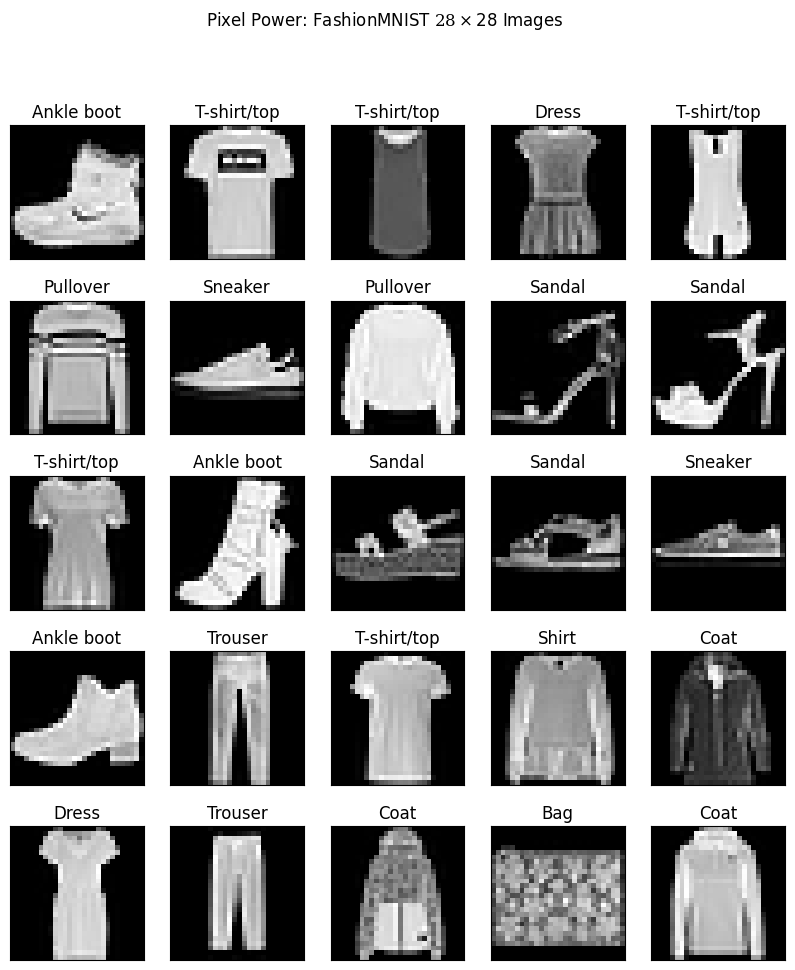

In [17]:
fig = plt.figure(figsize=(10, 11))

img_tensors, img_labels = next(iter(DataLoader(train_set, batch_size=25)))

for i, (img_tensor, img_label) in enumerate(zip(img_tensors, img_labels)):
    img = np.squeeze(img_tensor)
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.set_title(train_set.classes[img_label])
    ax.imshow(img, cmap="gray")
fig.suptitle("Pixel Power: FashionMNIST $28\\times$28 Images")

### Some final data set-up!

We just have a train and test set. We also need a validation set.

Let's split the $60,000$ train images into $48,000$ train images and $12,000$ validation images.

| Split      | Num Images |
|------------|------------|
| Train      | $48,000$   |
| Validation | $12,000$   |
| Test       | $10,000$   |


In [18]:
images = np.arange(len(train_set))
np.random.shuffle(images)
slice_idx = int(0.20 * len(train_set))

train_sample = SubsetRandomSampler(images[slice_idx:])
val_sample = SubsetRandomSampler(images[:slice_idx])

A `Dataset` object yields samples and labels one at a time. We want to pass in multiple samples in "mini-batches" when we train a model. We also want to shuffle data at each epoch to reduce overfitting. To do this, we "load" the dataset into a `torch.utils.data.DataLoader` object, which does all this and more!

In [19]:
train_loader = DataLoader(train_set, sampler=train_sample, batch_size=32)
val_loader = DataLoader(train_set, sampler=val_sample, batch_size=32)

# No sampler here, since we're just using the whole test set here.
test_loader = DataLoader(test_set, batch_size=32)

### Building a Model


Our model should take a $28\times28$ tensor (remember, grayscale - so each pixel is just a float), do things and return a class label. There are 10 class labels, so the output should be tensor of size 10.


In [20]:
class SimpleNetwork(Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1 = Linear(28 * 28, 512)
        self.fc2 = Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, p=0.2, train=True)
        x = self.fc2(x)
        return x


Let's follow our image through the model (`forward()`).

Input => $1\times28\times28$

`x.view(-1,28*28)` converts this into a `[784]` tensor.
`t.relu(self.fc1(x))` applies the `ReLu` func to a `[512]` tensor. So `fc1` has reduced the $784$ element tensor to $512$ elements
`self.fc2(x)` reduces the $512$ element tensor to a $10$ element tensor, with each element representing one of our classes.

A few other things:

* `criterion` (Loss function) - `CrossEntropyLoss` is a common loss function for multi-class classification.
* `optim` - The optimizer we're going to use. We used `SGD` for Gradient descent, let's use something new this time: `Adam`!
* `num_epochs` - the number of times we pass the training set through the model. I've set it to $5$, be reasonable when increasing it!

In [21]:
simple_model = SimpleNetwork()
criterion = CrossEntropyLoss()
optim = Adam(simple_model.parameters())
num_epochs = 5
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
def train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs,
    device,
):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    torch.cuda.empty_cache()
    print(f"{model.__class__.__name__} Training")

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        train_total = 0
        train_correct = 0

        print(f"Epoch: {epoch} Train Loop")
        # Train the model for this epoch
        model.train()
        for inputs, labels in tqdm(train_loader):
            # Zero the gradients.
            optim.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Compute the loss, using our criterion
            loss = criterion(outputs, labels)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()  # update weight
            optimizer.zero_grad()  # reset gradients

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        print(f"Training Loss {train_loss} Training Accuracy {train_acc}")

        # Evaluate the model
        print(f"Epoch: {epoch} Validation Loop")
        model.eval()

        val_correct = 0
        val_total = 0
        val_loss = 0

        # Turn autograd off! We don't want to track gradient changes here.
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

        print(LINESEP)

    return model, history

In [23]:
%%time
trained_model, model_history = train_model(
    model=simple_model,
    criterion=criterion,
    optimizer=optim,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    device=device,
)

SimpleNetwork Training
Epoch: 1 Train Loop


  0%|          | 0/1500 [00:00<?, ?it/s]

Training Loss 0.5294342583815257 Training Accuracy 0.8102291666666667
Epoch: 1 Validation Loop


  0%|          | 0/375 [00:00<?, ?it/s]

Validation Loss: 0.43208558489878973 Validation Accuracy: 0.843
--------------------------------------------------------------------------------
Epoch: 2 Train Loop


  0%|          | 0/1500 [00:00<?, ?it/s]

Training Loss 0.39877298937241235 Training Accuracy 0.8553125
Epoch: 2 Validation Loop


  0%|          | 0/375 [00:00<?, ?it/s]

Validation Loss: 0.3757349102894465 Validation Accuracy: 0.8575
--------------------------------------------------------------------------------
Epoch: 3 Train Loop


  0%|          | 0/1500 [00:00<?, ?it/s]

Training Loss 0.3642050172438224 Training Accuracy 0.8660625
Epoch: 3 Validation Loop


  0%|          | 0/375 [00:00<?, ?it/s]

Validation Loss: 0.3569376051425934 Validation Accuracy: 0.869
--------------------------------------------------------------------------------
Epoch: 4 Train Loop


  0%|          | 0/1500 [00:00<?, ?it/s]

Training Loss 0.34185117067644993 Training Accuracy 0.8739375
Epoch: 4 Validation Loop


  0%|          | 0/375 [00:00<?, ?it/s]

Validation Loss: 0.3339820276300112 Validation Accuracy: 0.87725
--------------------------------------------------------------------------------
Epoch: 5 Train Loop


  0%|          | 0/1500 [00:00<?, ?it/s]

Training Loss 0.32397320569554966 Training Accuracy 0.8810625
Epoch: 5 Validation Loop


  0%|          | 0/375 [00:00<?, ?it/s]

Validation Loss: 0.31961313636104266 Validation Accuracy: 0.88075
--------------------------------------------------------------------------------
CPU times: user 1min 12s, sys: 40.8 s, total: 1min 53s
Wall time: 1min 26s


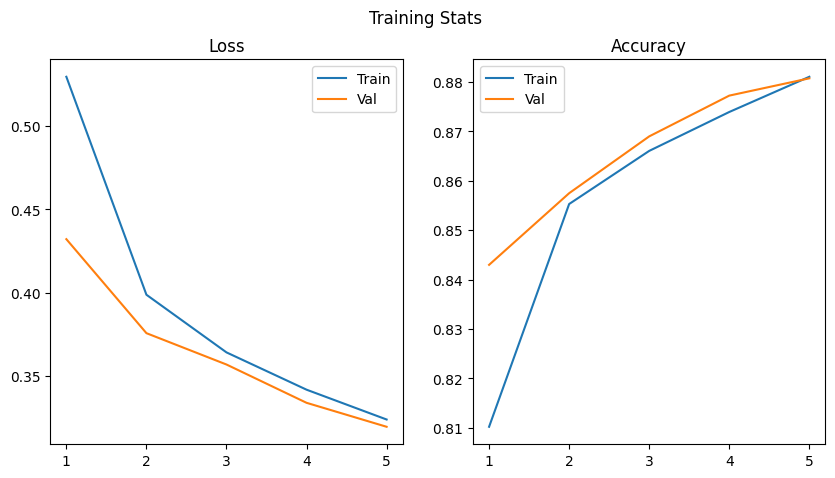

In [24]:
def plot_history(history):
    epochs = list(range(1, len(history["val_loss"]) + 1))
    fig = plt.figure(figsize=(10, 5))

    ax0 = fig.add_subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=history["train_loss"], ax=ax0, label="Train")
    sns.lineplot(x=epochs, y=history["val_loss"], ax=ax0, label="Val")
    ax0.set_title("Loss")
    ax0.legend()

    ax1 = fig.add_subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=history["train_acc"], ax=ax1, label="Train")
    sns.lineplot(x=epochs, y=history["val_acc"], ax=ax1, label="Val")
    ax1.set_title("Accuracy")
    ax1.legend()

    fig.suptitle("Training Stats")
    plt.show()


plot_history(model_history)

SimpleNetwork Evaluation
Test Loop:


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.8676999807357788
CPU times: user 1.34 s, sys: 220 ms, total: 1.56 s
Wall time: 1.37 s


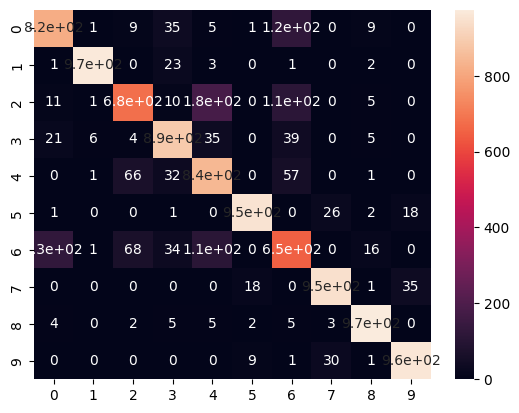

In [25]:
%%time


def test_model(model, test_loader, num_classes, device):
    torch.cuda.empty_cache()
    print(f"{model.__class__.__name__} Evaluation")

    pred = []
    true = []
    model.to(device)
    model.eval()
    print("Test Loop:")
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # We don't care about loss, etc here, we're just trying to get predictions.

            pred.append(predicted)
            true.append(labels)

    pred_labels = torch.cat(pred)
    true_labels = torch.cat(true)

    accuracy = multiclass_accuracy(
        pred_labels, true_labels, num_classes=num_classes
    ).item()
    cmatrix = multiclass_confusion_matrix(
        pred_labels, true_labels, num_classes=num_classes
    ).tolist()
    sns.heatmap(cmatrix, annot=True)

    print(f"Accuracy: {accuracy}")


test_model(
    model=trained_model, test_loader=test_loader, num_classes=num_classes, device=device
)

## Saving your models

Model training is time-consuming and computationally expensive. It is not practical to train a model every time you want to make an inference. A common PyTorch convention is to save models using either a `.pt` or `.pth` file extension.

Remember to call `model.eval()` to set your dropout and batch normalization layers to evaluation mode before running inference. 

### `torch.save` and `torch.load`

This is an extremely intuitive way to save and load your model. Torch pickles your entire model to a file. 
```python
torch.save(my_model, 'checkpoints/my_model.pth')
```
The downside is that the pickled data is bound to the specific classes and the exact directory structure used when the model is saved. It does not save the model class itself, instead it saves a path to a file containing your model class, which is used during load time. 
```python
model = torch.load(PATH)
model.eval()
```

SimpleNetwork Evaluation
Test Loop:


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.8689000010490417


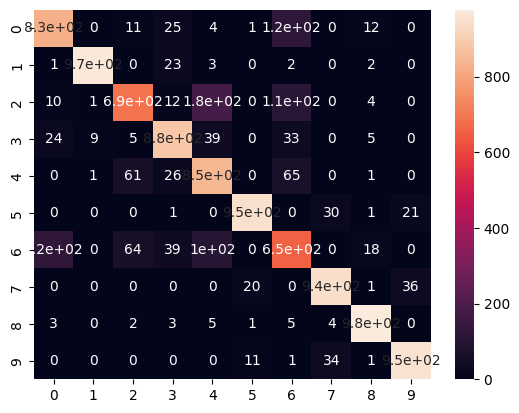

In [26]:
torch.save(trained_model, "mnist-model.pth")

loaded_model = torch.load("mnist-model.pth")
test_model(
    model=loaded_model,
    test_loader=test_loader,
    num_classes=num_classes,
    device=device,
)

### Using `.state_dict` and `.load_state_dict`

A model's `state_dict` maps each model layer to its parameter tensor. Using this method is more robust, but its slightly more involved.
```python
torch.save(my_model.state_dict(), 'checkpoints/my_model.pth')
```

To load a model, you need to create a model instance.
```python
model = MyModel(*args, **kwargs)
model.load_state_dict(torch.load('checkpoints/my_model.pth'))
model.eval()
```



SimpleNetwork Evaluation
Test Loop:


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.8709999918937683


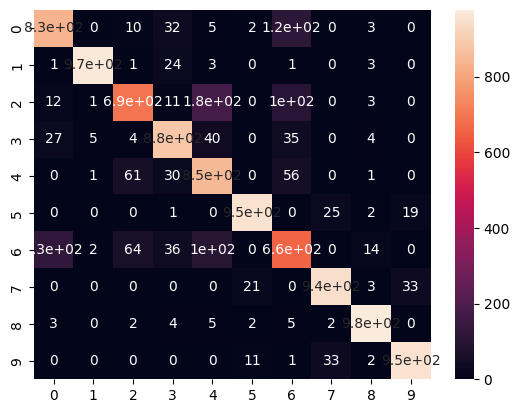

In [27]:
torch.save(trained_model.state_dict(), "mnist-model-save-dict.pth")

loaded_model = SimpleNetwork()
loaded_model.load_state_dict(torch.load("mnist-model-save-dict.pth"))

test_model(
    model=loaded_model,
    test_loader=test_loader,
    num_classes=num_classes,
    device=device,
)

[PyTorch Documentation](https://pytorch.org/docs/stable/index.html)